### Load packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import gensim
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Conv1D, MaxPooling1D, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import Model

In [3]:
#biowordvec embeddings
#https://github.com/ncbi-nlp/BioWordVec
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Crowdfunding/bio_embedding_extrinsic.bin', binary=True)

### Import and clean data

In [121]:
#read mesh disease data
df = pd.read_csv('/content/drive/MyDrive/Crowdfunding/mesh_with_mental_health.csv')
df = df[['termName','group']]
df = df.rename(columns={'termName':'text','group':'label'})

In [128]:
# df = pd.read_csv('/content/drive/MyDrive/Crowdfunding/chv.csv')
# chv = df.rename(columns={'chv_str':'text','group':'label'})
# df = pd.concat([mesh, chv])

In [122]:
mesh_dic = {
  'Infections'                                                      : 'C01',
  'Neoplasms'                                                       : 'C04', 
  'Musculoskeletal Diseases'                                        : 'C05',
  'Digestive System Diseases'                                       : 'C06',
  'Stomatognathic Diseases'                                         : 'C07',
  'Respiratory Tract Diseases'                                      : 'C08', 
  'Otorhinolaryngologic Diseases'                                   : 'C09', 
  'Nervous System Diseases'                                         : 'C10', 
  'Eye Diseases'                                                    : 'C11',
  'Male Urogenital Diseases'                                        : 'C12', 
  'Female Urogenital Diseases and Pregnancy Complications'          : 'C13',
  'Cardiovascular Diseases'                                         : 'C14', 
  'Hemic and Lymphatic Diseases'                                    : 'C15',
  'Congenital, Hereditary, and Neonatal Diseases and Abnormalities' : 'C16',
  'Skin and Connective Tissue Diseases'                             : 'C17',
  'Nutritional and Metabolic Diseases'                              : 'C18',
  'Endocrine System Diseases'                                       : 'C19',
  'Immune System Diseases'                                          : 'C20', 
  'Disorders of Environmental Origin'                               : 'C21',
  'Animal Diseases'                                                 : 'C22',
  'Pathological Conditions, Signs and Symptoms'                     : 'C23',
  'Occupational Diseases'                                           : 'C24',
  'Chemically-Induced Disorders'                                    : 'C25',
  'Wounds and Injuries'                                             : 'C26',
  'Mental Disorders'                                                : 'F03'
}
mesh_map = {v: k for k, v in mesh_dic.items()}

In [123]:
df = df[~df['label'].isin(['C21','C22','C25'])]
df = df.replace(mesh_map)
df = df.replace({
  'Male Urogenital Diseases'                                        : 'Genitourinary Diseases',
  'Female Urogenital Diseases and Pregnancy Complications'          : 'Genitourinary Diseases',
  'Eye Diseases'                                                    : 'Other Noncommunicable Diseases',
  'Stomatognathic Diseases'                                         : 'Other Noncommunicable Diseases',
  'Otorhinolaryngologic Diseases'                                   : 'Other Noncommunicable Diseases',
  'Immune System Diseases'                                          : 'Other Noncommunicable Diseases',
  'Occupational Diseases'                                           : 'Other Noncommunicable Diseases',
  'Hemic and Lymphatic Diseases'                                    : 'Other Noncommunicable Diseases',
  'Skin and Connective Tissue Diseases'                             : 'Other Noncommunicable Diseases',
  'Endocrine System Diseases'                                       : 'Endocrine and Metabolic Diseases',
  'Nutritional and Metabolic Diseases'                              : 'Endocrine and Metabolic Diseases',
  'Digestive System Diseases'                                       : 'Gastrointestinal Diseases',
  'Congenital, Hereditary, and Neonatal Diseases and Abnormalities' : 'Congenital Abnormalities',
  'Mental Disorders'                                                : 'Mental Health Disorders'
})

In [87]:
#df = df.drop_duplicates('text')
df.shape

(100305, 2)

In [8]:
model.vectors.shape

(2324849, 200)

In [9]:
word_vectors = model

### Text preprocessing

In [124]:
texts = df.text.values
labels = df.label

In [125]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [126]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9582 unique tokens.


In [127]:
data = pad_sequences(sequences, maxlen=10)

#multiclass classification

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
labels = to_categorical(labels)



#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (104046, 10)
Shape of label tensor: (104046, 14)


Text(0.5, 0, 'Percent of terms (%)')

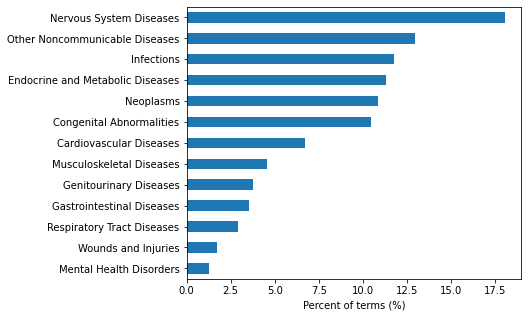

In [92]:
barplot_data = df['label'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 5))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of terms (%)')



In [128]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

# x_train = data
# y_train = labels

In [16]:
embeddings_index = {}
for word, vocab_obj in word_vectors.vocab.items():
  embeddings_index[word] = word_vectors[word]
print('Found %s word vectors.' % len(embeddings_index))

Found 2324849 word vectors.


In [129]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [130]:
embedding_matrix.shape

(9583, 200)

In [131]:
labels.shape

(104046, 14)

### Build classification model

In [132]:
embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=10,
                            trainable=False)

In [133]:
# #binary
# model = Sequential()
# model.add(embedding_layer)
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#multiclass
deep_inputs = Input(shape=(10,))
embedding_layer = Embedding(embedding_matrix.shape[0], 200, weights=[embedding_matrix], trainable=True)(deep_inputs)
LSTM_Layer_1 = LSTM(64)(embedding_layer)
dense_layer_1 = Dense(labels.shape[1], activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# summarize the model
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 10, 200)           1916600   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_3 (Dense)              (None, 14)                910       
Total params: 1,985,350
Trainable params: 1,985,350
Non-trainable params: 0
_________________________________________________________________
None


### Train and evaluate model

In [134]:
# fit the model
history_train = model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
2602/2602 [==============================] - 34s 13ms/step - loss: 0.7517 - acc: 0.7734 - val_loss: 0.0977 - val_acc: 0.9726
Epoch 2/10
2602/2602 [==============================] - 34s 13ms/step - loss: 0.0505 - acc: 0.9868 - val_loss: 0.0519 - val_acc: 0.9855
Epoch 3/10
2602/2602 [==============================] - 33s 13ms/step - loss: 0.0178 - acc: 0.9954 - val_loss: 0.0464 - val_acc: 0.9876
Epoch 4/10
2602/2602 [==============================] - 33s 13ms/step - loss: 0.0097 - acc: 0.9976 - val_loss: 0.0474 - val_acc: 0.9872
Epoch 5/10
2602/2602 [==============================] - 33s 13ms/step - loss: 0.0064 - acc: 0.9982 - val_loss: 0.0420 - val_acc: 0.9895
Epoch 6/10
2602/2602 [==============================] - 32s 12ms/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.0447 - val_acc: 0.9900
Epoch 7/10
2602/2602 [==============================] - 32s 12ms/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0468 - val_acc: 0.9904
Epoch 8/10
2602/2602 [==========================

In [135]:
# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss))

Accuracy: 99.989188
Loss: 0.000716


In [136]:
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss))

Accuracy: 99.043685
Loss: 0.054419


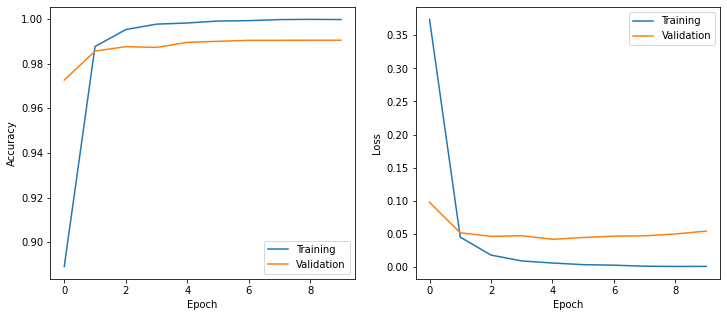

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(history_train.history['acc'])
axes[0].plot(history_train.history['val_acc'])
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'], loc='lower right')

axes[1].plot(history_train.history['loss'])
axes[1].plot(history_train.history['val_loss'])
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'], loc='upper right')


In [138]:
class_dic = {}
n = 0
for c in sorted(df['label'].unique()):
  class_dic[n] = c
  n = n + 1

In [139]:
class_dic

{0: 'Cardiovascular Diseases',
 1: 'Congenital Abnormalities',
 2: 'Endocrine and Metabolic Diseases',
 3: 'Gastrointestinal Diseases',
 4: 'Genitourinary Diseases',
 5: 'Infections',
 6: 'Mental Health Disorders',
 7: 'Musculoskeletal Diseases',
 8: 'Neoplasms',
 9: 'Nervous System Diseases',
 10: 'Other Noncommunicable Diseases',
 11: 'Pathological Conditions, Signs and Symptoms',
 12: 'Respiratory Tract Diseases',
 13: 'Wounds and Injuries'}

In [184]:
test_sequences = tokenizer.texts_to_sequences([
'tumor'
])
test_data = pad_sequences(test_sequences, maxlen=10)
y_prob = model.predict(test_data)
y_classes = y_prob.argmax(axis=-1)

In [185]:
y_prob

array([[2.8007241e-07, 3.3859064e-06, 5.1742107e-05, 2.4354902e-06,
        3.5465860e-06, 8.8229790e-08, 4.4375363e-07, 9.0106533e-07,
        9.9288356e-01, 6.6696499e-03, 7.6823617e-06, 3.7403192e-04,
        1.6651391e-06, 5.6635463e-07]], dtype=float32)

In [106]:
if np.amax(y_prob) < 0.9:
  print('Nonspecific', np.amax(y_prob),class_dic[y_classes[0]])
else:
  print(class_dic[y_classes[0]], np.amax(y_prob))

Neoplasms 0.99056107


# Evaluate on labeled data

In [140]:
data = pd.read_csv('/content/drive/MyDrive/Crowdfunding/elmo_ner_for_manual_review_annotated.csv')

In [141]:
label_map = {
    'card': 'Cardiovascular Diseases',
    'cong': 'Congenital Abnormalities',
    'endo': 'Endocrine and Metabolic Diseases',
    'gi': 'Gastrointestinal Diseases',
    'gu': 'Genitourinary Diseases',
    'inf': 'Infections',
    'p': 'Mental Health Disorders',
    'msk': 'Musculoskeletal Diseases',
    'neo': 'Neoplasms',
    'neuro': 'Nervous System Diseases',
    'onc': 'Other Noncommunicable Diseases',
    'ss': 'Pathological Conditions, Signs and Symptoms',
    'resp': 'Respiratory Tract Diseases',
    'inj': 'Wounds and Injuries',
    'ns': 'Nonspecific'
}

In [142]:
data['label'] = data['label'].replace(label_map)

Text(0.5, 0, 'Percent of terms (%)')

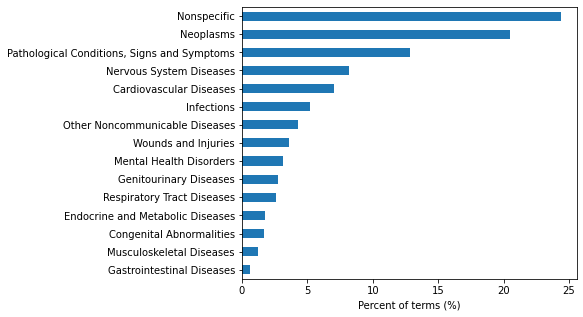

In [143]:
barplot_data = data['label'].value_counts(normalize=True).sort_values(ascending=True) * 100
plt.figure(figsize=(6, 5))
ax = barplot_data.plot(kind='barh')
ax.set_xlabel('Percent of terms (%)')

### Process text

In [144]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english') + list(string.punctuation))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [145]:
def Clean(l):
  r = []
  for sent in l:
    clean = ' '.join([i for i in word_tokenize(sent.lower()) if i not in stop]).strip()
    r.append(clean)
  return r

In [146]:
#lowercase
#remove stopwords
#remove punctuation
#strip whitespace
data['text_clean'] = Clean(data['token'])

### Model predictions

In [147]:
from sklearn.metrics import accuracy_score

In [148]:
df = data
df['label'] = df['label'].replace({'Pathological Conditions, Signs and Symptoms':'Nonspecific'})

In [42]:
print(data.shape)
print(df.shape)

(1112, 3)
(1112, 3)


In [167]:
class_dic = {}
n = 0
for c in sorted(df['label'].unique()):
  class_dic[n] = c
  n = n + 1
class_dic 

{0: 'Cardiovascular Diseases',
 1: 'Congenital Abnormalities',
 2: 'Endocrine and Metabolic Diseases',
 3: 'Gastrointestinal Diseases',
 4: 'Genitourinary Diseases',
 5: 'Infections',
 6: 'Mental Health Disorders',
 7: 'Musculoskeletal Diseases',
 8: 'Neoplasms',
 9: 'Nervous System Diseases',
 10: 'Nonspecific',
 11: 'Other Noncommunicable Diseases',
 12: 'Respiratory Tract Diseases',
 13: 'Wounds and Injuries'}

In [156]:
test_sequences = tokenizer.texts_to_sequences(data['text_clean'].tolist())
test_data = pad_sequences(test_sequences, maxlen=10)
y_prob = model.predict(test_data)
y_classes = y_prob.argmax(axis=-1)

In [157]:
def GetLabels(y_prob, y_classes, class_dic, y_true):
  r = {}
  for c in np.linspace(0,1,11):
    c = round(c, 2)
    preds = []
    for i in range(len(y_prob)):
      if np.amax(y_prob[i]) < c:
        preds.append('Nonspecific')
      else:
        if class_dic[y_classes[i]] == 'Pathological Conditions, Signs and Symptoms':
          preds.append('Nonspecific')
        else:
          preds.append(class_dic[y_classes[i]])
    acc = accuracy_score(preds, y_true)
    r[c] = acc
  return r

In [158]:
GetLabels(y_prob, y_classes, class_dic, df['label'].tolist())

{0.0: 0.7491007194244604,
 0.1: 0.7491007194244604,
 0.2: 0.7491007194244604,
 0.3: 0.7491007194244604,
 0.4: 0.75,
 0.5: 0.7517985611510791,
 0.6: 0.7607913669064749,
 0.7: 0.7535971223021583,
 0.8: 0.7553956834532374,
 0.9: 0.7428057553956835,
 1.0: 0.4136690647482014}

In [176]:
y_clazz = []
for i in range(len(y_prob)):
  if np.amax(y_prob[i]) < 0.6:
    y_clazz.append(10)
  else:
    if class_dic[y_classes[i]] == 'Pathological Conditions, Signs and Symptoms':
      y_clazz.append(10)
    else:
      y_clazz.append(y_classes[i])

In [177]:
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
y_pred  = to_categorical(y_clazz)

In [159]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [162]:
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
y_true  = to_categorical(labels)

In [178]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [182]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(14)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(14):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 14

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


In [181]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

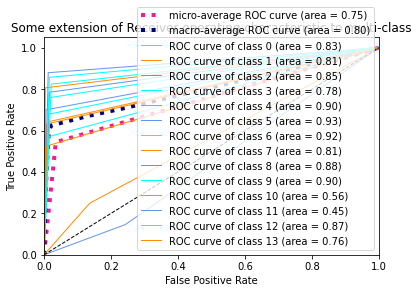

In [183]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(14), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

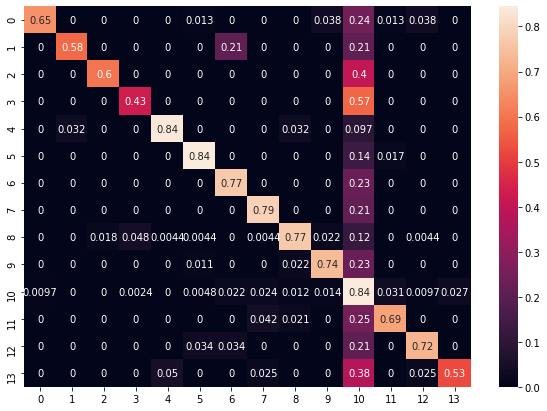

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(df['label'].tolist(), preds[9], normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [46]:
for i in range(0,5):
  print(class_dic[y_classes[i]])

Mental Health Disorders
Pathological Conditions, Signs and Symptoms
Infections
Other Noncommunicable Diseases
Mental Health Disorders


In [47]:
df['label'].tolist()[:5]

['Mental Health Disorders',
 'Nonspecific',
 'Infections',
 'Other Noncommunicable Diseases',
 'Mental Health Disorders']

In [117]:
y = [class_dic[x] for x in y_classes]

In [118]:
for i in range(40,50):
  print(df['text_clean'][i],' - ',df['label'].tolist()[i],' - ',y[i])

neural tube defects  -  Nervous System Diseases  -  Nervous System Diseases
pregnant  -  Genitourinary Diseases  -  Other Noncommunicable Diseases
fluid leaking ryleigh 's lower spinal area  -  Nervous System Diseases  -  Nervous System Diseases
spinal fluid  -  Nervous System Diseases  -  Nervous System Diseases
leaking fluid  -  Nonspecific  -  Nervous System Diseases
enlarged ventricles  -  Nervous System Diseases  -  Cardiovascular Diseases
swelling brain  -  Nervous System Diseases  -  Nervous System Diseases
leaking fluid  -  Nonspecific  -  Nervous System Diseases
leak  -  Nonspecific  -  Cardiovascular Diseases
pain  -  Nonspecific  -  Other Noncommunicable Diseases
